In [59]:
# CS180 (CS280A): Project 1 starter Python code

# these are just some suggested libraries
# instead of scikit-image you could use matplotlib and opencv to read, write, and display images

import numpy as np
import skimage as sk
import skimage.io as skio
import logging
import matplotlib.pyplot as plt
import skimage.exposure as exposure
import skimage.color as color
import os
import scipy
import cv2

# set up logging
# levels are DEBUG, INFO, WARNING, ERROR, CRITICAL
logging.basicConfig(level=logging.CRITICAL)


In [45]:
def load_image_as_float(imname):
    # concatenate the image name with the path
    imname = '../../../data/' + imname
    im = skio.imread(imname)
    # convert to float (might want to do this later on to save memory)
    im = sk.img_as_float(im)
    return im

# part 1.1 Finite difference operator


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'iCCP' 41 2345
DEBUG:PIL.PngImagePlugin:iCCP profile name b'icc'
DEBUG:PIL.PngImagePlugin:Compression method 0
DEBUG:PIL.PngImagePlugin:STREAM b'cHRM' 2398 32
DEBUG:PIL.PngImagePlugin:STREAM b'bKGD' 2442 6
DEBUG:PIL.PngImagePlugin:b'bKGD' 2442 6 (unknown)
DEBUG:PIL.PngImagePlugin:STREAM b'oFFs' 2460 9
DEBUG:PIL.PngImagePlugin:b'oFFs' 2460 9 (unknown)
DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 2481 9
DEBUG:PIL.PngImagePlugin:STREAM b'tIME' 2502 7
DEBUG:PIL.PngImagePlugin:b'tIME' 2502 7 (unknown)
DEBUG:PIL.PngImagePlugin:STREAM b'vpAg' 2521 9
DEBUG:PIL.PngImagePlugin:b'vpAg' 2521 9 (unknown)
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 2542 32768
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'iCCP' 41 2345
DEBUG:PIL.PngImagePlugin:iCCP profile name b'icc'
DEBUG:PIL.PngImagePlugin:Compression method 0
DEBUG:PIL.PngImagePlugin:STREAM b'cHRM' 2398 32
DEBUG:PIL.PngImagePlugin:STREAM b'bKGD

(542, 540)

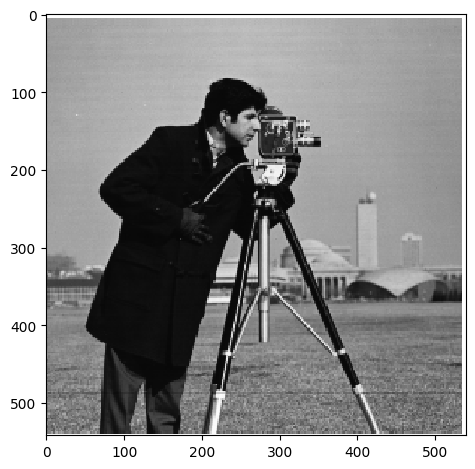

In [80]:
# load the image
im = sk.img_as_float(skio.imread('../../../data/cameraman.png', as_gray = True))
# show image
skio.imshow(im)
# show dimensions
im.shape

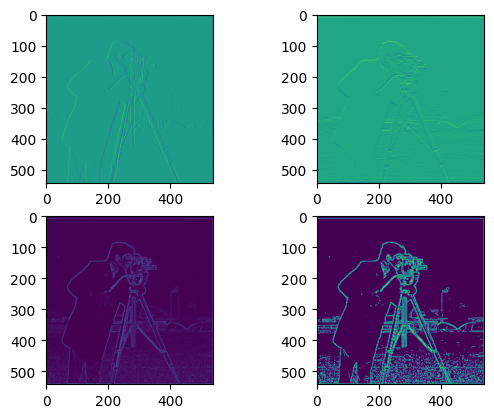

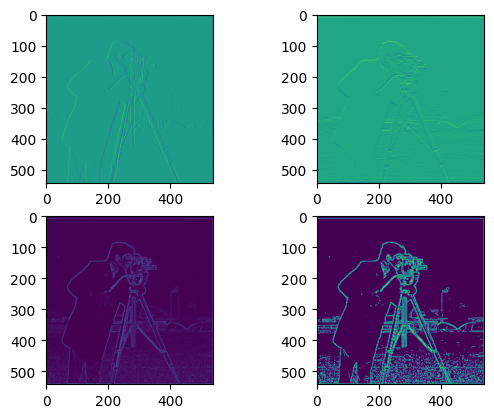

In [82]:
# define the finite difference operator
Dx = np.array([[-1, 1]])
Dy = np.array([[-1], [1]])

def convolveWithEdgeOperator(im):
    # convolve the image with the edge operator
    im_dx = scipy.signal.convolve2d(im, Dx, mode='same')
    im_dy = scipy.signal.convolve2d(im, Dy, mode='same')
    return im_dx, im_dy

def gradientMagnitude(im1, im2):
    # calculate the gradient magnitude
    return np.sqrt(im1**2 + im2**2)

def edgeOperatorNoSmoothing(im):
    # use the scipy.signal convolve 2d operator
    im_dx, im_dy = convolveWithEdgeOperator(im)
    im_mag = gradientMagnitude(im_dx, im_dy)
    # binarize the image
    THRESHOLD = 0.1
    im_binary = im_mag > THRESHOLD
    return im_binary

images = []
im_dx, im_dy = convolveWithEdgeOperator(im)
images.append(im_dx)
images.append(im_dy)
im_mag = gradientMagnitude(im_dx, im_dy)
images.append(im_mag)
im_binary = edgeOperatorNoSmoothing(im)
images.append(im_binary)
skio.imshow_collection(images)

# Part 1.2

In [67]:
def createGauss2d():
    # create a gaussian kernel (1D)
    gauss1D = cv2.getGaussianKernel(5, 1)
    # take the outer product of its transpose to create a 2d gaussian kernel
    transposeGauss1D = np.transpose(gauss1D)
    gauss2D = np.outer(gauss1D, transposeGauss1D)
    return gauss2D

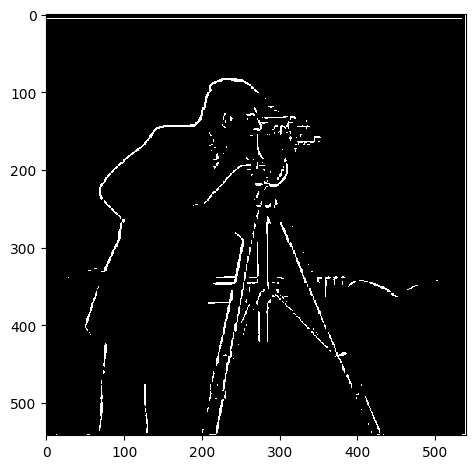

In [68]:
gauss2D = createGauss2d()
# create blurred image by convolvulving image with gaussian kernel
blurredIm = scipy.signal.convolve2d(im, gauss2D, mode='same')
# convolve with the edge operator
basicSmoothEdge = edgeOperatorNoSmoothing(blurredIm)
skio.imshow(basicSmoothEdge)    


This outline does a much better job at picking up on only edges that define the outline of objects, and not random static. Therefore making it more effective.

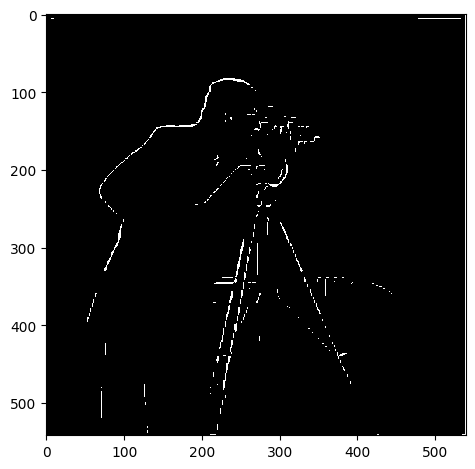

In [65]:
# Single convolution gaussian + edge operator
# convulve gaussian kernel with edge operator
gaussEdge_x = scipy.signal.convolve2d(gauss2D, Dx, mode='same')
gaussEdge_y = scipy.signal.convolve2d(gauss2D, Dy, mode='same')
# convolve image with gaussian edge operator
im_gauss_edge_x = scipy.signal.convolve2d(im, gaussEdge_x, mode='same')
im_gauss_edge_y = scipy.signal.convolve2d(im, gaussEdge_y, mode='same')
# binarize the image
THRESHOLD = 0.1
im_binary_gauss_edge_x = im_gauss_edge_x > THRESHOLD
im_binary_gauss_edge_y = im_gauss_edge_y > THRESHOLD
# combine the images
im_binary_gauss_edge = im_binary_gauss_edge_x + im_binary_gauss_edge_y
skio.imshow(im_binary_gauss_edge)


# PART 2: FUN WITH FREQUENCIES

DEBUG:PIL.TiffImagePlugin:tag: XResolution (282) - type: rational (5) Tag Location: 22 - Data Location: 62 - value: b'\x00\x00\x00\x90\x00\x00\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: YResolution (283) - type: rational (5) Tag Location: 34 - Data Location: 70 - value: b'\x00\x00\x00\x90\x00\x00\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: ResolutionUnit (296) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x00\x00\x00N'


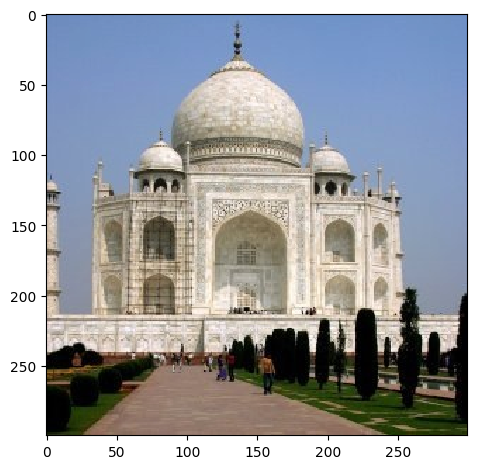

In [71]:
im = sk.img_as_float(skio.imread('../../../data/Taj.jpg'))
skio.imshow(im)

In [75]:
def createImpulseKernel():
    # create impulse kernel (meant to not change image) (OG)
    impulseKernel = np.zeros((5, 5))
    impulseKernel[2, 2] = 1
    return impulseKernel

# create the unsharp mark filter (OG - smooth)
def unsharpMarkFilter(amount=0.5):
    # create impulse kernel (meant to not change image) (OG)
    impulseKernel = createImpulseKernel()
    # create gaussian kernel
    gauss2D = createGauss2d()
    # subtract to get final filter (OG - smooth)
    unsharpMarkFilter = impulseKernel - (gauss2D * amount)
    return unsharpMarkFilter

def applyUnsharpMarkFilter(im, amount=0.5):
    # apply the unsharp mark filter to the image
    filter = unsharpMarkFilter(amount)
    im_unsharp = scipy.signal.convolve2d(im, filter, mode='same')
    return im_unsharp

im_unsharp = applyUnsharpMarkFilter(im)
skio.imshow(im_unsharp)

ValueError: convolve2d inputs must both be 2-D arrays

In [ ]:
# apply to taj